# Tactical Asset Allocation using Reinforcement Learning

# Import Libraries

In [264]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import yfinance as yf

%matplotlib inline

In [265]:
# Disabling the display of warnings
import warnings
warnings.filterwarnings('ignore')

# Create Folders

In [266]:
# Create folders for stroing data, models, logs and results
import os
if not os.path.exists("./datasets"):
    os.makedirs("./datasets")
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models")
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log")
if not os.path.exists("./results"):
    os.makedirs("./results")

# Download Data

We will work with the 30 stocks comprising the Dow Jones Industrial Average (DJIA Index). We use the yfinance library to download the data for these stocks from Yahoo Finance spanning from July 2009 to June 2022. 

In [267]:
# Importing Data for the 30 Dow Jones Industrial Average (DJIA Index) Stocks
tickers = [
    "AAPL", "MSFT", "JPM", "V", "RTX",
    "PG", "GS", "NKE", "DIS", "AXP",
    "HD", "INTC", "WMT", "IBM", "MRK",
    "UNH", "KO", "CAT", "TRV", "JNJ",
    "CVX", "MCD", "VZ", "CSCO", "XOM",
    "BA", "MMM", "PFE", "WBA", "DD",
]
#tickers = config.DOW_30_TICKER

#Download the data
df = yf.download([tickers][0], start='2009-07-02', end="2022-07-01", time_interval="1D")

[*********************100%***********************]  30 of 30 completed


# Clean Data
The data needs to be checked for Missing values which have to filled or dropped.

In [268]:
data = df.copy()

data = data.stack().reset_index()
data.columns.names = [None]
data = data.drop(['Close'], axis=1)

data.head()

,Date,level_1,Adj Close,High,Low,Open,Volume
0,2009-07-01,AAPL,4.361508,5.166429,5.090000,5.125000,414178800
1,2009-07-01,AXP,18.965475,23.549999,22.969999,23.490000,13523000
2,2009-07-01,BA,32.309608,42.950001,42.150002,42.630001,6346700
3,2009-07-01,CAT,23.138065,34.150002,33.150002,33.480000,11585100
4,2009-07-01,CSCO,13.474447,19.100000,18.760000,18.840000,36650000


In [269]:
# rename columns of the dataset for better readability
data.columns = ['date','tic','close','high','low','open','volume']

data.head()

,date,tic,close,high,low,open,volume
0,2009-07-01,AAPL,4.361508,5.166429,5.090000,5.125000,414178800
1,2009-07-01,AXP,18.965475,23.549999,22.969999,23.490000,13523000
2,2009-07-01,BA,32.309608,42.950001,42.150002,42.630001,6346700
3,2009-07-01,CAT,23.138065,34.150002,33.150002,33.480000,11585100
4,2009-07-01,CSCO,13.474447,19.100000,18.760000,18.840000,36650000


In [270]:
data.shape

(98190, 7)

In [271]:
# Check for na values
data.isna().sum()

date      0
tic       0
close     0
high      0
low       0
open      0
volume    0
dtype: int64

In [272]:
# Check if all tickers have the same number of data points

no_datasets = []
for i in tickers:
    no_data_points = data[data['tic']==i].shape[0]
    no_datasets.append((i,no_data_points))
    data_points_df = pd.DataFrame(no_datasets)
    
data_points_df

,0,1
0,AAPL,3273
1,MSFT,3273
2,JPM,3273
3,V,3273
4,RTX,3273
5,PG,3273
6,GS,3273
7,NKE,3273
8,DIS,3273
9,AXP,3273


In [273]:
# Save data to csv
data.to_csv('./datasets/data.csv', index=False)

In [274]:
# Create dataset of only daily close prices
df_prices = data

# Reset the index to tic and date
df_prices = df_prices.reset_index().set_index(['tic', 'date']).sort_index()

# Get the list of all the tickers
tic_list = list(set([i for i,j in df_prices.index]))

len(tic_list)

30

In [275]:
# Create an empty data frame for the close prices
df_close = pd.DataFrame()

# Reset the Index to tic and date
df_prices = df_prices.reset_index().set_index(['tic', 'date']).sort_index()

# Get all the Close Prices
df_close = pd.DataFrame()

for ticker in tic_list:
    series = df_prices.xs(ticker).close
    df_close[ticker] = series
    
df_close = df_close.reset_index()

df_close.head()

,date,AXP,GS,MMM,NKE,BA,JNJ,PFE,DIS,VZ,...,KO,RTX,CSCO,MRK,UNH,MCD,PG,INTC,XOM,JPM
0,2009-07-01,18.965475,121.075661,42.377720,11.188940,32.309608,38.958809,8.663266,20.192780,15.355934,...,16.437607,24.117737,13.474447,16.988773,20.862974,40.061893,34.958282,11.540547,43.103706,24.386162
1,2009-07-02,18.363531,117.927963,42.035862,10.898649,31.238493,38.214722,8.419069,19.667507,15.037055,...,16.337328,23.176641,13.259433,16.358875,19.826462,39.532047,34.359970,11.323822,41.839184,23.302977
2,2009-07-06,19.394255,120.368904,42.328880,11.080082,31.031919,38.651634,8.471397,19.882786,15.126739,...,16.377439,23.481115,13.280935,16.891859,19.975716,39.903625,35.072571,11.201917,41.600933,23.541277
3,2009-07-07,18.660378,117.147194,40.996300,10.930669,29.868992,38.385395,8.483026,19.400568,14.768002,...,16.257114,22.802973,13.073081,16.728331,20.871267,39.084774,34.897774,11.005508,40.660187,23.692919
4,2009-07-08,18.734589,113.868004,41.177708,10.994704,30.259171,38.965649,8.494655,19.150850,14.499764,...,16.213667,22.918308,12.994239,16.982712,20.456661,39.249931,35.388538,10.795555,40.476925,23.620708


In [276]:
# Get statistics on daily close dataset
df_close.describe().T

,count,mean,std,min,25%,50%,75%,max
AXP,3273.0,79.742398,38.350867,18.363531,49.796593,72.813667,97.691025,197.080933
GS,3273.0,180.684952,73.069076,73.799072,134.640457,162.507858,208.216614,416.602905
MMM,3273.0,123.946983,46.908428,40.996300,70.264397,131.093613,162.857376,223.317764
NKE,3273.0,58.484817,40.785551,10.898649,23.769209,50.260189,80.523224,176.351196
BA,3273.0,156.675060,101.589668,29.868992,61.994476,123.051193,219.940002,430.299988
JNJ,3273.0,94.907415,40.153996,38.214722,52.716232,87.513580,125.179550,184.822342
PFE,3273.0,24.866490,10.576317,8.256269,16.149658,24.706566,31.951166,59.831848
DIS,3273.0,88.359050,43.972403,19.150850,44.668694,94.430977,111.230621,201.910004
VZ,3273.0,36.516601,11.938968,14.264590,28.306566,35.588509,48.677647,56.941429
MSFT,3273.0,86.758702,84.977047,17.046047,24.352816,46.661777,115.327988,341.606384


In [277]:
# Save the Daily Close Price dataset to csv

df_close.to_csv('./datasets/close_prices.csv', index=False)

## Plot of stock prices over time

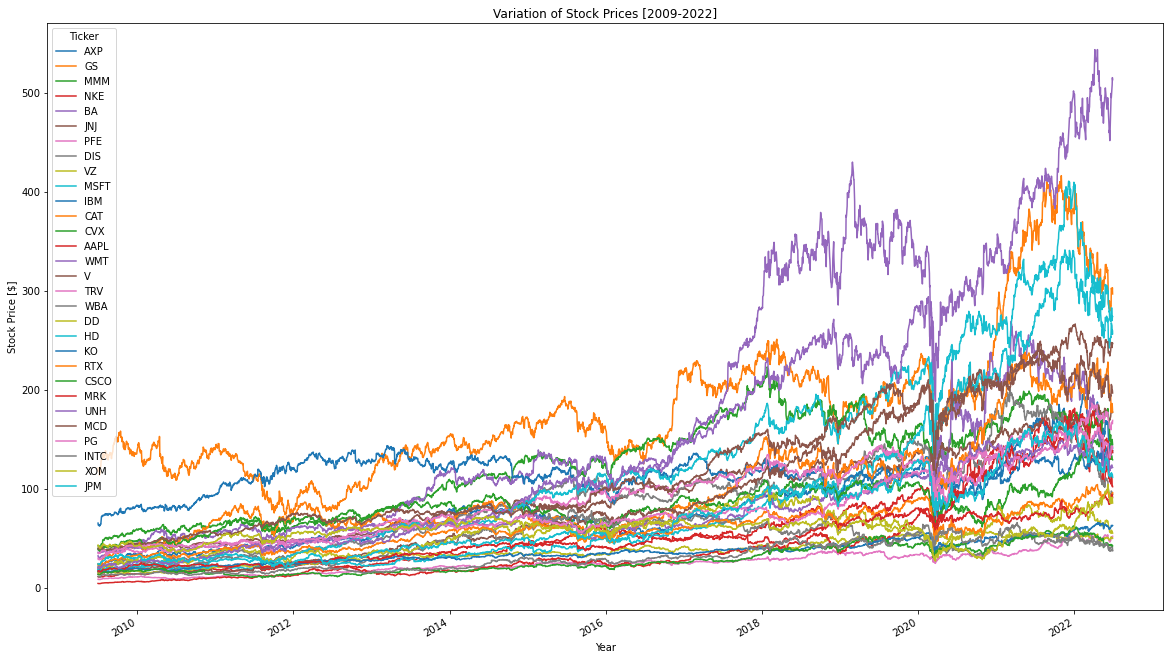

In [279]:
df_close_indexed = df_close.reset_index(drop=True).set_index(['date'])

df_close_indexed.plot(kind = 'line', figsize = (20, 12))
plt.xlabel('Year')
plt.ylabel('Stock Price [$]')
plt.legend(loc = 'best',title = 'Ticker')
plt.title('Variation of Stock Prices [2009-2022]')
plt.show()

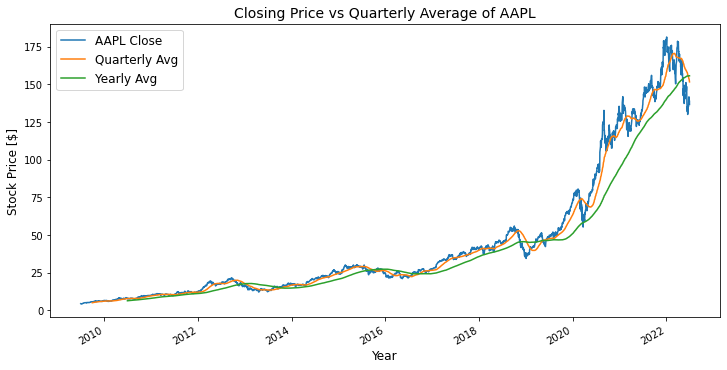

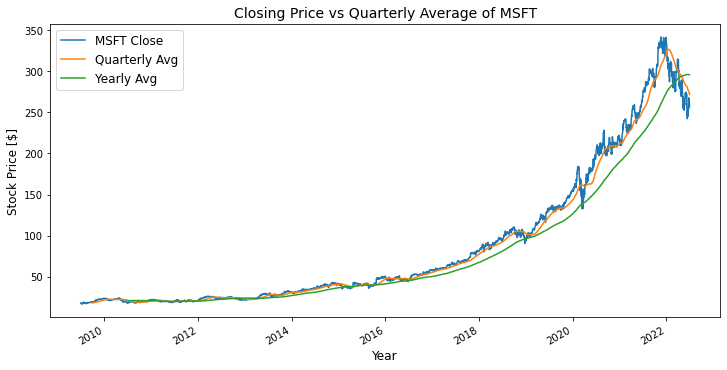

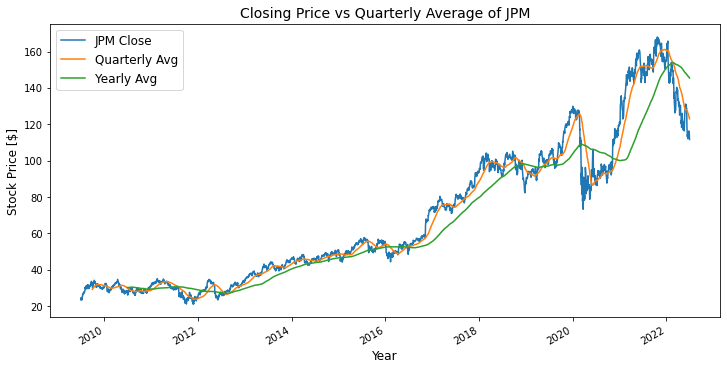

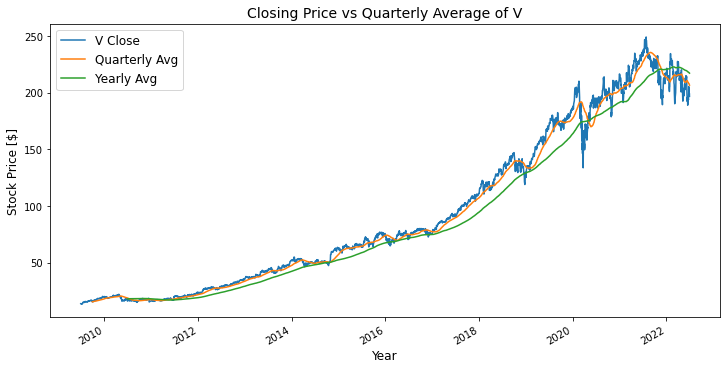

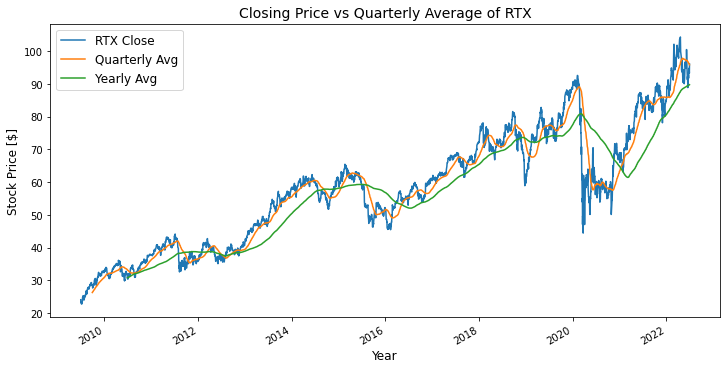

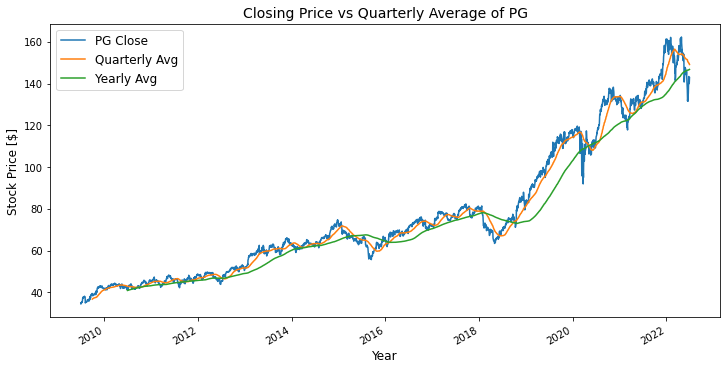

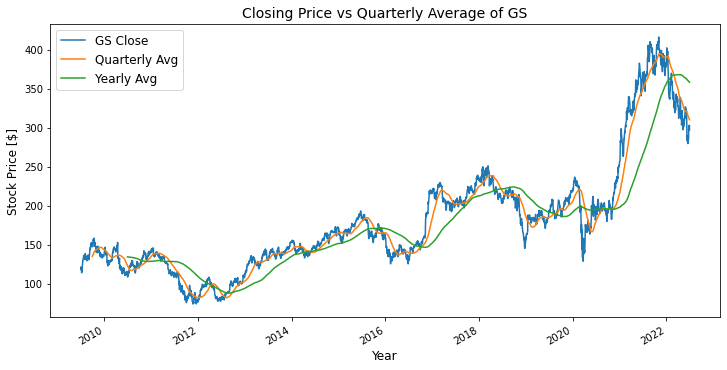

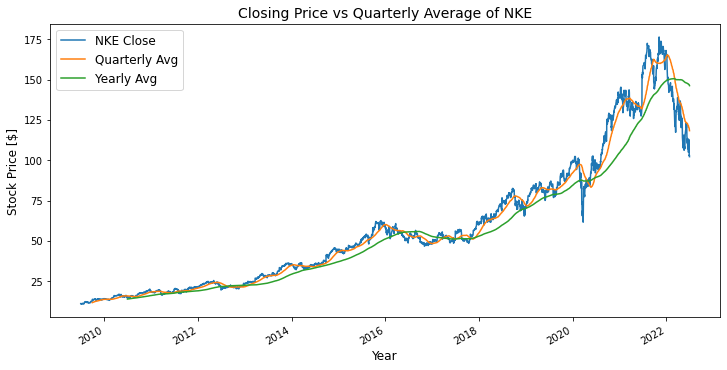

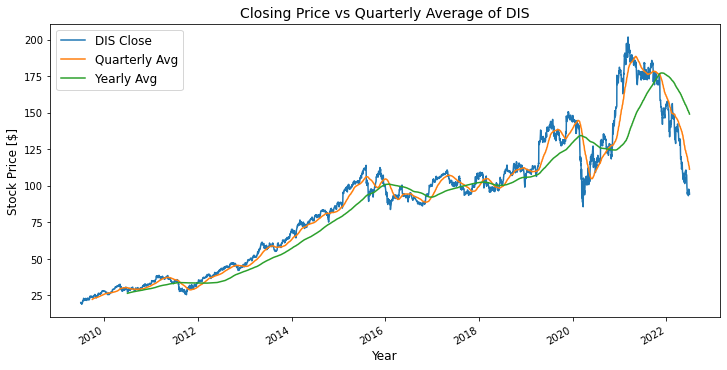

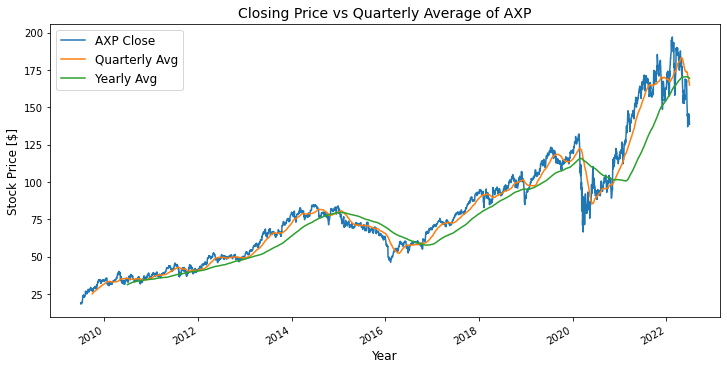

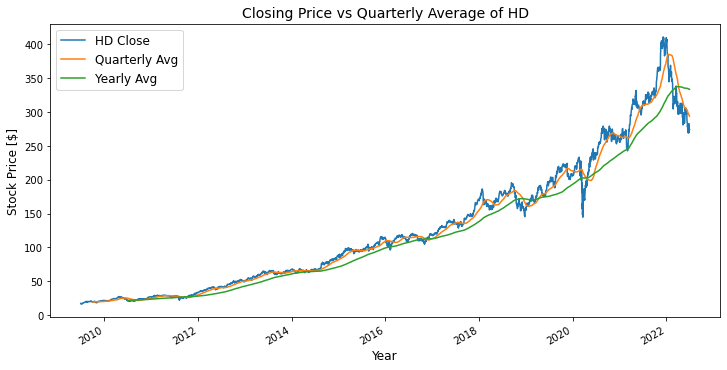

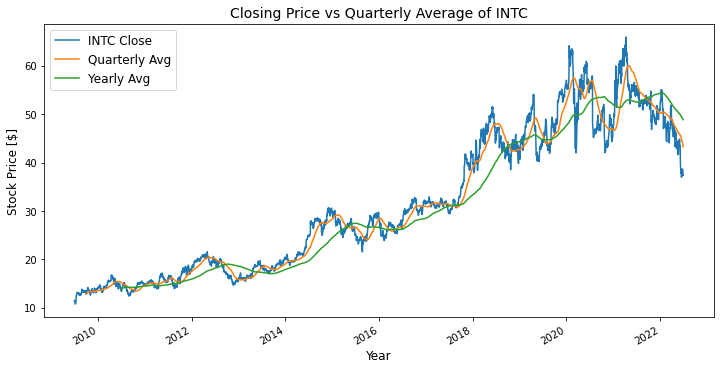

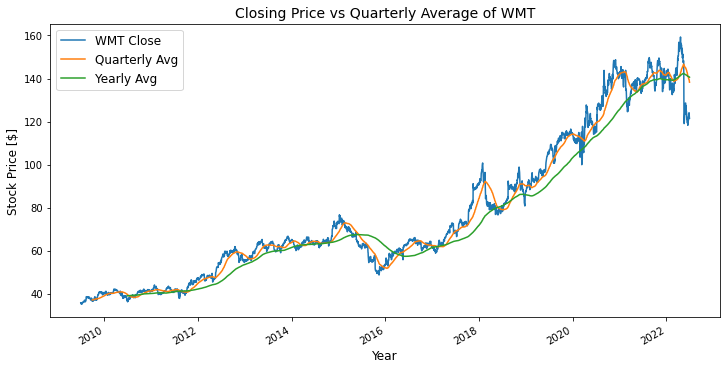

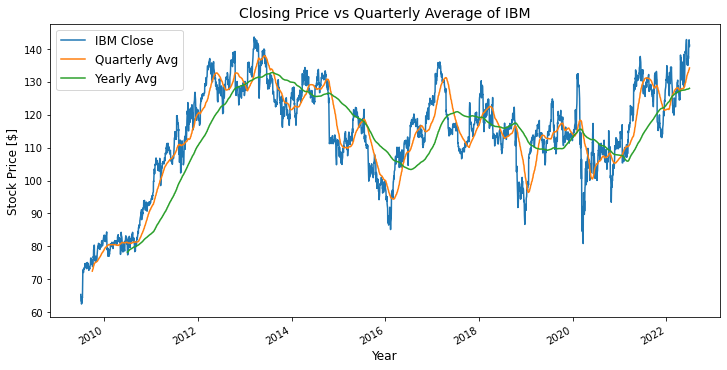

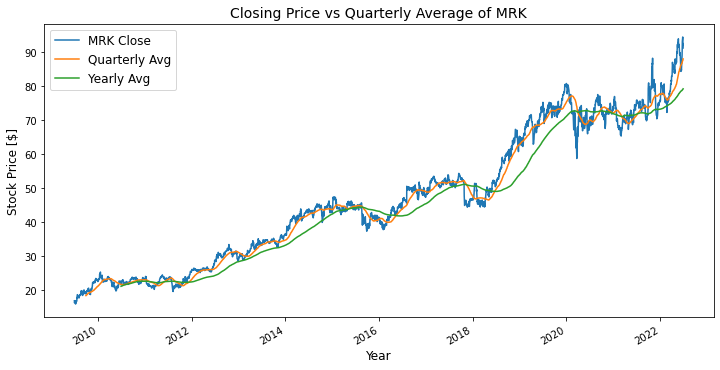

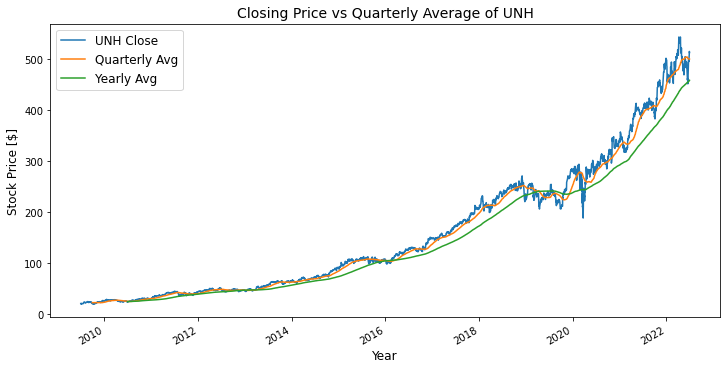

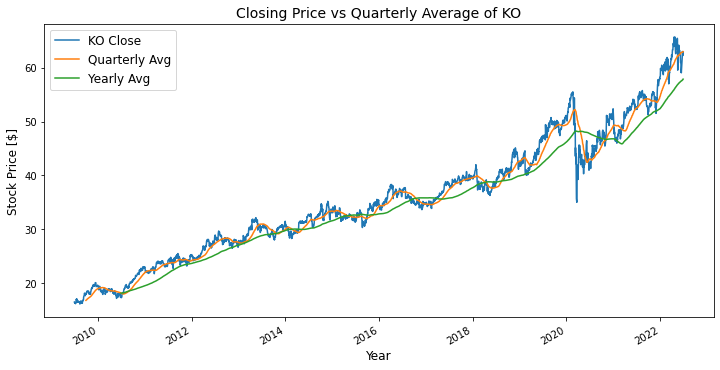

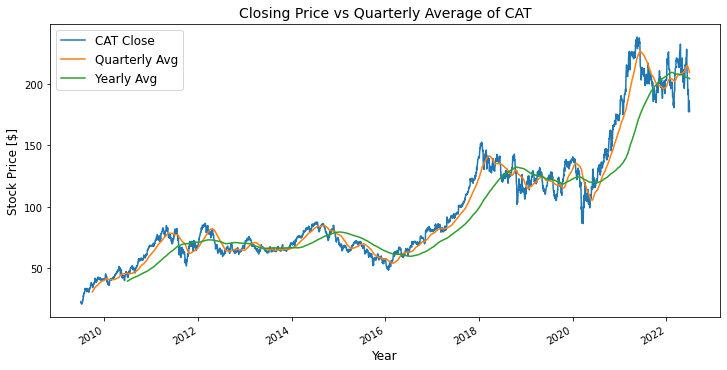

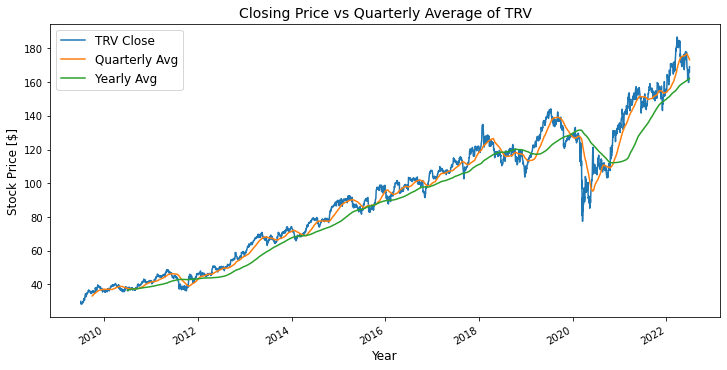

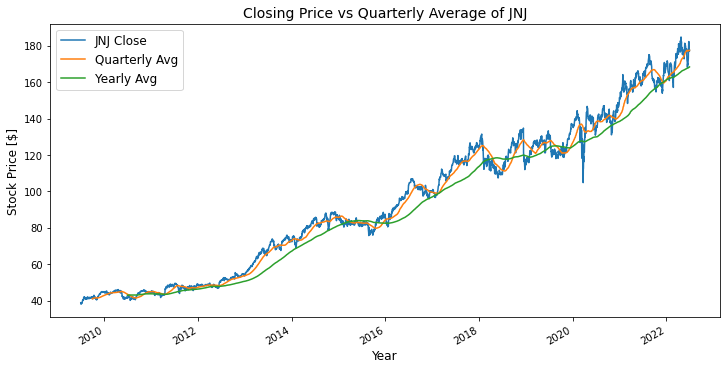

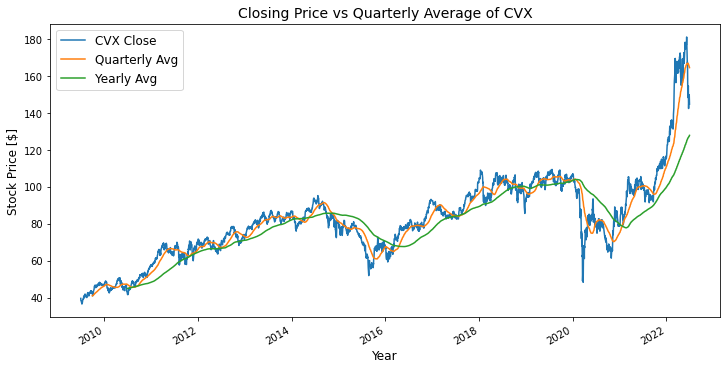

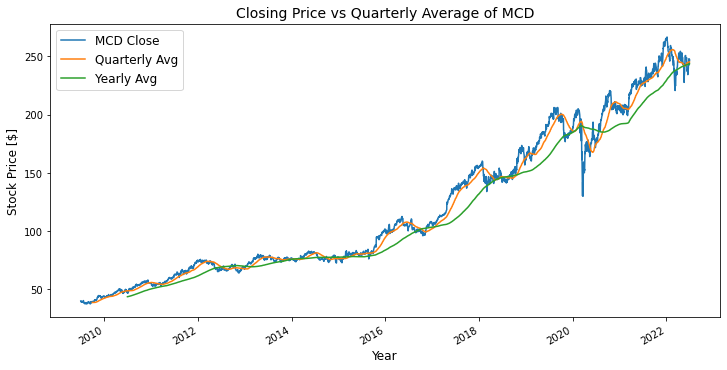

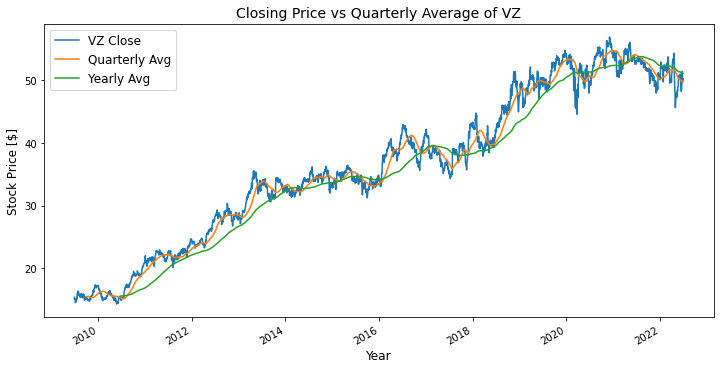

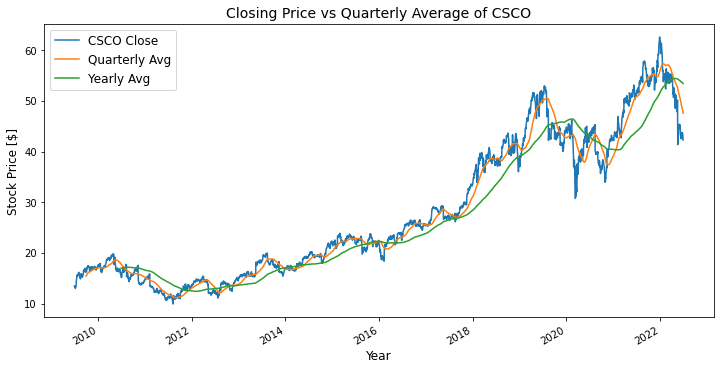

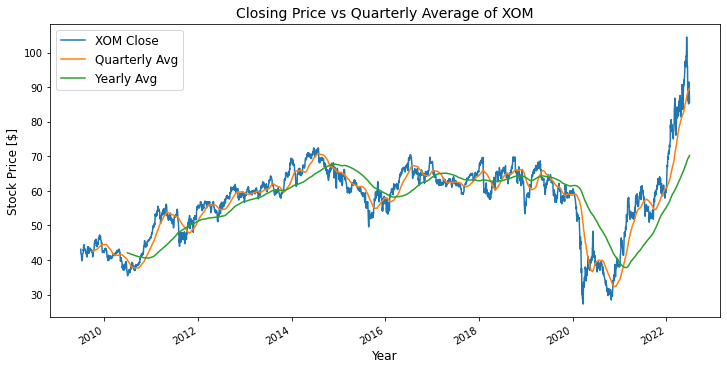

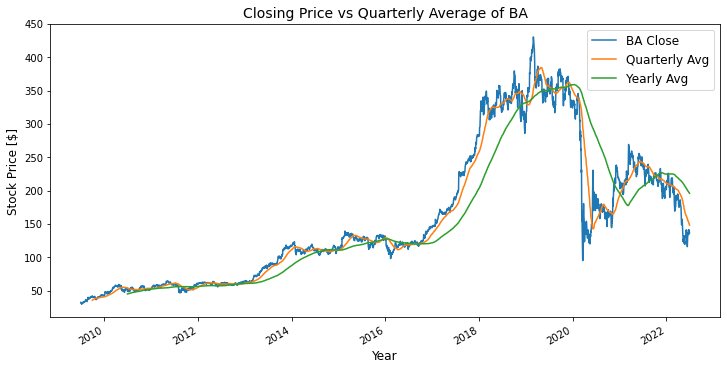

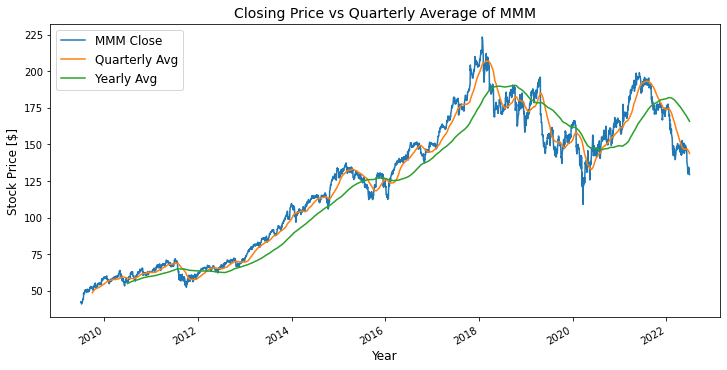

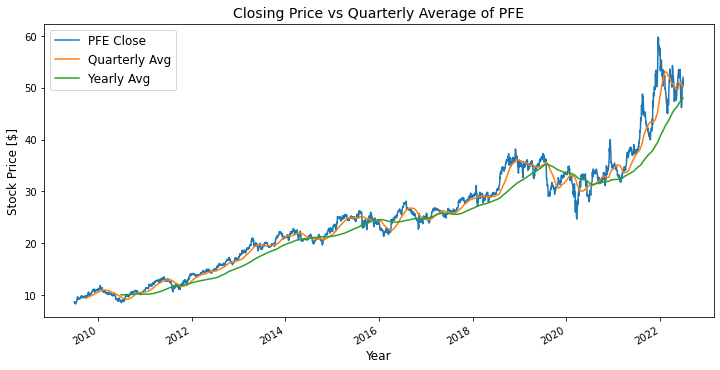

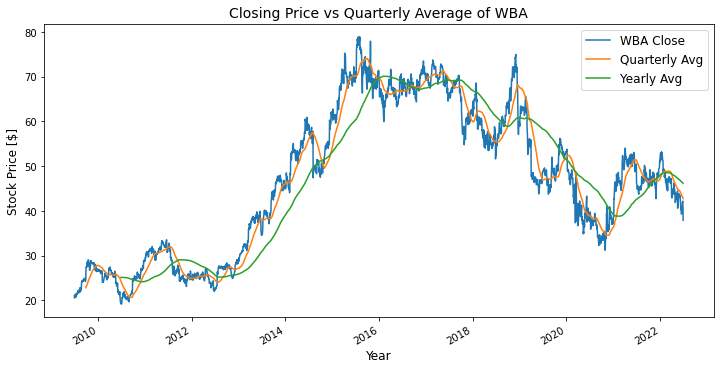

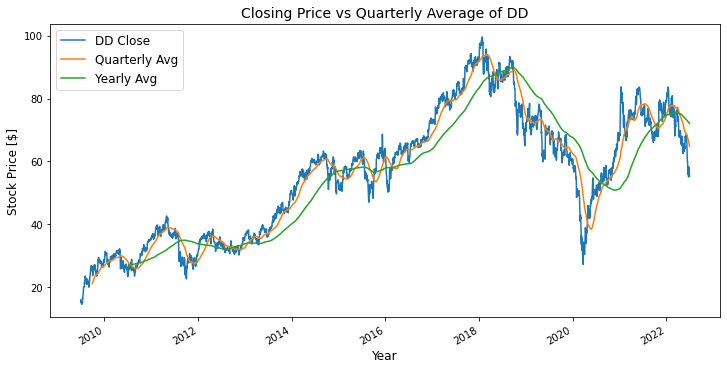

In [280]:
for idx in tickers:
    plt.figure(figsize=(12,6))
    df_close_indexed[idx].loc['2009-01-01':].plot(label = '{} Close'.format(idx))
    df_close_indexed[idx].loc['2009-01-01':].rolling(window=63).mean().plot(label='Quarterly Avg')
    df_close_indexed[idx].loc['2009-01-01':].rolling(window=252).mean().plot(label='Yearly Avg')
    plt.xlabel('Year', fontsize = 12)
    plt.ylabel('Stock Price [$]', fontsize = 12)
    plt.legend(loc = 'best', fontsize = 12)
    plt.title('Closing Price vs Quarterly Average of {}'.format(idx), fontsize = 14)
    plt.show()

# Preprocessing Data

In [15]:
## install finrl library
#!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [281]:
import sys
sys.path.append("../FinRL-Library")

In [282]:
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

## Adding Technical Indicators to the data 
We use FinRL library to add the following technical indicators to the data
- Moving Average Convergence Divergence
- Bollinger Band Upper Bound 
- Bollinger Band Lower Bound
- Relative Strength Index
- Commodity Channel Index
- Average Directional Movement Index
- Simple Moving Average

In [283]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(data)

Successfully added technical indicators


In [284]:
df.shape

(98190, 15)

In [285]:
df.head()

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2009-07-01,AAPL,4.361508,5.166429,5.090000,5.125000,414178800,0.0,4.439955,4.197252,0.0,-66.666667,100.0,4.361508,4.361508
3273,2009-07-01,AXP,18.965475,23.549999,22.969999,23.490000,13523000,0.0,4.439955,4.197252,0.0,-66.666667,100.0,18.965475,18.965475
6546,2009-07-01,BA,32.309608,42.950001,42.150002,42.630001,6346700,0.0,4.439955,4.197252,0.0,-66.666667,100.0,32.309608,32.309608
9819,2009-07-01,CAT,23.138065,34.150002,33.150002,33.480000,11585100,0.0,4.439955,4.197252,0.0,-66.666667,100.0,23.138065,23.138065
13092,2009-07-01,CSCO,13.474447,19.100000,18.760000,18.840000,36650000,0.0,4.439955,4.197252,0.0,-66.666667,100.0,13.474447,13.474447


## Adding covariance matrix to data

In [286]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [287]:
df.shape

(90630, 17)

In [288]:
df.head()

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2010-07-01,AAPL,7.587675,9.100000,8.686429,9.082143,1022896000,0.032319,8.555577,7.340978,48.375901,-66.005643,29.682907,7.858104,7.808365,"[[0.00032542576708652164, 0.000240896785419699...",tic AAPL AXP BA ...
1,2010-07-01,AXP,33.162739,40.080002,38.419998,39.549999,8747200,-0.068211,36.700129,31.276522,46.700334,-50.346911,27.488170,33.684402,35.470600,"[[0.00032542576708652164, 0.000240896785419699...",tic AAPL AXP BA ...
2,2010-07-01,BA,49.130005,62.720001,61.310001,62.480000,6465100,-0.388980,55.756183,46.911807,43.954428,-90.121794,33.935175,50.995467,53.648251,"[[0.00032542576708652164, 0.000240896785419699...",tic AAPL AXP BA ...
3,2010-07-01,CAT,43.198231,60.700001,58.060001,59.669998,11598200,-0.048393,49.155443,39.785252,46.634808,-50.060190,23.024502,44.077047,46.010455,"[[0.00032542576708652164, 0.000240896785419699...",tic AAPL AXP BA ...
4,2010-07-01,CSCO,15.237594,21.490000,20.930000,21.200001,66345400,-0.469482,17.179469,15.339108,35.922584,-280.011467,44.711760,16.411832,17.677689,"[[0.00032542576708652164, 0.000240896785419699...",tic AAPL AXP BA ...


# Model Implementation and Training

## Split data into train and trade data

In [25]:
train = data_split(df, '2010-07-01','2016-06-30')

In [26]:
train.head()

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2010-07-01,AAPL,7.587672,9.100000,8.686429,9.082143,1022896000,0.032319,8.555577,7.340977,48.375866,-66.005788,29.682907,7.858103,7.808365,"[[0.0003254260727963856, 0.0002408959807116002...",tic AAPL AXP BA ...
0,2010-07-01,AXP,33.162746,40.080002,38.419998,39.549999,8747200,-0.068211,36.700133,31.276518,46.700343,-50.346745,27.488170,33.684403,35.470600,"[[0.0003254260727963856, 0.0002408959807116002...",tic AAPL AXP BA ...
0,2010-07-01,BA,49.130009,62.720001,61.310001,62.480000,6465100,-0.388980,55.756186,46.911801,43.954451,-90.121723,33.935175,50.995466,53.648251,"[[0.0003254260727963856, 0.0002408959807116002...",tic AAPL AXP BA ...
0,2010-07-01,CAT,43.198250,60.700001,58.060001,59.669998,11598200,-0.048392,49.155438,39.785254,46.634851,-50.059982,23.024502,44.077046,46.010455,"[[0.0003254260727963856, 0.0002408959807116002...",tic AAPL AXP BA ...
0,2010-07-01,CSCO,15.237595,21.490000,20.930000,21.200001,66345400,-0.469482,17.179470,15.339107,35.922696,-280.011120,44.711760,16.411832,17.677689,"[[0.0003254260727963856, 0.0002408959807116002...",tic AAPL AXP BA ...


In [351]:
trade = data_split(df,'2016-07-02', '2022-06-30')

In [352]:
trade.head()

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2016-07-05,AAPL,22.058529,23.850000,23.615000,23.847500,110820800,-0.186526,23.287861,21.387457,45.382971,-77.028641,8.565729,22.534117,22.765993,"[[0.0003188615189379905, 7.760844486674582e-05...",tic AAPL AXP BA ...
0,2016-07-05,AXP,54.147312,60.389999,58.959999,60.220001,4911800,-1.075322,60.910205,52.000948,43.186657,-105.047580,27.338488,57.494246,57.916885,"[[0.0003188615189379905, 7.760844486674582e-05...",tic AAPL AXP BA ...
0,2016-07-05,BA,115.862106,129.000000,126.629997,128.429993,4829400,-0.632786,123.863166,112.949241,47.555328,-50.439406,13.241873,117.906753,118.828149,"[[0.0003188615189379905, 7.760844486674582e-05...",tic AAPL AXP BA ...
0,2016-07-05,CAT,63.063824,75.949997,73.699997,75.660004,4776300,0.132457,66.972704,61.016834,50.558128,6.971436,4.119782,63.236782,63.422900,"[[0.0003188615189379905, 7.760844486674582e-05...",tic AAPL AXP BA ...
0,2016-07-05,CSCO,23.533195,28.620001,28.219999,28.230000,22116900,0.019840,24.439456,22.757520,53.001714,-45.158512,2.445117,23.646122,23.134816,"[[0.0003188615189379905, 7.760844486674582e-05...",tic AAPL AXP BA ...


# Reinforcement Learning Models
## Environment setup for training and trading

In [27]:
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')

from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.max_portfolio_value = 0        
        self.mdd = 0.0001


        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            # self.reward = (new_portfolio_value-self.initial_amount)/self.initial_amount
            now_return = (new_portfolio_value-self.initial_amount)/self.initial_amount
            ann_return = (1+now_return) ** (252/self.day) -1
            if self.max_portfolio_value <  new_portfolio_value :
                self.max_portfolio_value = new_portfolio_value
            now_dd = 1-(new_portfolio_value/self.max_portfolio_value)
            if self.mdd < now_dd:
                self.mdd = now_dd    

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [28]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 30


In [29]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [30]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## Training Model 1: A2C

In [37]:
# initialize
agent = DRLAgent(env = env_train)

In [38]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {
    "n_steps": 5, 
    "ent_coef": 0.005, 
    "learning_rate": 0.0002
}

model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [39]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 373       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.82e+08  |
|    reward             | 1471801.5 |
|    std                | 0.996     |
|    value_loss         | 2.37e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 377       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.4     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 360       |
|    iterations         | 1400      |
|    time_elapsed       | 19        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -42.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 1399      |
|    policy_loss        | 2.96e+08  |
|    reward             | 2218808.5 |
|    std                | 0.993     |
|    value_loss         | 5.14e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 363       |
|    iterations         | 1500      |
|    time_elapsed       | 20        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -42.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 359       |
|    iterations         | 2700      |
|    time_elapsed       | 37        |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -42.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 2699      |
|    policy_loss        | 2.81e+08  |
|    reward             | 2307946.5 |
|    std                | 0.988     |
|    value_loss         | 5.33e+13  |
-------------------------------------
begin_total_asset:1000000
end_total_asset:2523315.7284033736
Sharpe:  1.1305797919888763
-------------------------------------
| time/                 |           |
|    fps                | 356       |
|    iterations         | 2800      |
|    time_elapsed       | 39        |
|    total_timesteps    | 14000     |
| train/                |           |
|    entropy_loss       | -42.2     |

begin_total_asset:1000000
end_total_asset:2560505.866953593
Sharpe:  1.1412372339591792
-------------------------------------
| time/                 |           |
|    fps                | 357       |
|    iterations         | 4000      |
|    time_elapsed       | 55        |
|    total_timesteps    | 20000     |
| train/                |           |
|    entropy_loss       | -42.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 3999      |
|    policy_loss        | 1.7e+08   |
|    reward             | 1328537.9 |
|    std                | 0.985     |
|    value_loss         | 1.96e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 358       |
|    iterations         | 4100      |
|    time_elapsed       | 57        |
|    total_timesteps    | 20500     |
| train/                |           |
|    entropy_loss       | -42.1     |


-------------------------------------
| time/                 |           |
|    fps                | 356       |
|    iterations         | 5300      |
|    time_elapsed       | 74        |
|    total_timesteps    | 26500     |
| train/                |           |
|    entropy_loss       | -42       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 5299      |
|    policy_loss        | 2.39e+08  |
|    reward             | 1971144.2 |
|    std                | 0.982     |
|    value_loss         | 3.9e+13   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 356       |
|    iterations         | 5400      |
|    time_elapsed       | 75        |
|    total_timesteps    | 27000     |
| train/                |           |
|    entropy_loss       | -42       |
|    explained_variance | 2.38e-07  |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 344       |
|    iterations         | 6600      |
|    time_elapsed       | 95        |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -41.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 6599      |
|    policy_loss        | 3.22e+08  |
|    reward             | 2489445.2 |
|    std                | 0.977     |
|    value_loss         | 6.54e+13  |
-------------------------------------
begin_total_asset:1000000
end_total_asset:2642009.1520119198
Sharpe:  1.1787819401768853
-------------------------------------
| time/                 |           |
|    fps                | 343       |
|    iterations         | 6700      |
|    time_elapsed       | 97        |
|    total_timesteps    | 33500     |
| train/                |           |
|    entropy_loss       | -41.9     |

begin_total_asset:1000000
end_total_asset:2648281.831393629
Sharpe:  1.1865042351528643
-------------------------------------
| time/                 |           |
|    fps                | 340       |
|    iterations         | 7900      |
|    time_elapsed       | 116       |
|    total_timesteps    | 39500     |
| train/                |           |
|    entropy_loss       | -41.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 7899      |
|    policy_loss        | 1.51e+08  |
|    reward             | 1331489.9 |
|    std                | 0.972     |
|    value_loss         | 1.9e+13   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 339       |
|    iterations         | 8000      |
|    time_elapsed       | 117       |
|    total_timesteps    | 40000     |
| train/                |           |
|    entropy_loss       | -41.7     |


-------------------------------------
| time/                 |           |
|    fps                | 331       |
|    iterations         | 9200      |
|    time_elapsed       | 138       |
|    total_timesteps    | 46000     |
| train/                |           |
|    entropy_loss       | -41.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 9199      |
|    policy_loss        | 2.09e+08  |
|    reward             | 1798263.9 |
|    std                | 0.968     |
|    value_loss         | 3.42e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 331       |
|    iterations         | 9300      |
|    time_elapsed       | 140       |
|    total_timesteps    | 46500     |
| train/                |           |
|    entropy_loss       | -41.6     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updat

In [40]:
trained_a2c.save('./trained_models/trained_a2c.zip')

## Training Model 2: PPO

In [34]:
agent = DRLAgent(env = env_train)

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}

model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [35]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

begin_total_asset:1000000
end_total_asset:2464649.3186642495
Sharpe:  1.0987740200195533
----------------------------------
| time/              |           |
|    fps             | 558       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1516825.2 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2600141.7839872534
Sharpe:  1.16732220191035
---------------------------------------
| time/                   |           |
|    fps                  | 508       |
|    iterations           | 2         |
|    time_elapsed         | 8         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | 0         |
|    learning_rate        | 0

begin_total_asset:1000000
end_total_asset:2569727.789993977
Sharpe:  1.1472801056124842
---------------------------------------
| time/                   |           |
|    fps                  | 444       |
|    iterations           | 10        |
|    time_elapsed         | 46        |
|    total_timesteps      | 20480     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0001    |
|    loss                 | 4.81e+14  |
|    n_updates            | 90        |
|    policy_gradient_loss | -7.5e-07  |
|    reward               | 1951346.6 |
|    std                  | 1         |
|    value_loss           | 9.49e+14  |
---------------------------------------
begin_total_asset:1000000
end_total_asset:2514032.7293021893
Sharpe:  1.1233541727815677
-----------------------

---------------------------------------
| time/                   |           |
|    fps                  | 433       |
|    iterations           | 18        |
|    time_elapsed         | 84        |
|    total_timesteps      | 36864     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0001    |
|    loss                 | 4.93e+14  |
|    n_updates            | 170       |
|    policy_gradient_loss | -7.55e-07 |
|    reward               | 1592873.6 |
|    std                  | 1         |
|    value_loss           | 1.03e+15  |
---------------------------------------
begin_total_asset:1000000
end_total_asset:2676553.3585094777
Sharpe:  1.1990735020148724
---------------------------------------
| time/                   |           |
|    fps                  | 432

begin_total_asset:1000000
end_total_asset:2407817.9765241323
Sharpe:  1.0785226337007092
---------------------------------------
| time/                   |           |
|    fps                  | 425       |
|    iterations           | 27        |
|    time_elapsed         | 129       |
|    total_timesteps      | 55296     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.0001    |
|    loss                 | 5.13e+14  |
|    n_updates            | 260       |
|    policy_gradient_loss | -7.95e-07 |
|    reward               | 2095543.5 |
|    std                  | 1         |
|    value_loss           | 9.15e+14  |
---------------------------------------
begin_total_asset:1000000
end_total_asset:2611113.474956808
Sharpe:  1.1699042104665338
-----------------------

---------------------------------------
| time/                   |           |
|    fps                  | 419       |
|    iterations           | 35        |
|    time_elapsed         | 170       |
|    total_timesteps      | 71680     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | -2.38e-07 |
|    learning_rate        | 0.0001    |
|    loss                 | 5.3e+14   |
|    n_updates            | 340       |
|    policy_gradient_loss | -7.73e-07 |
|    reward               | 1775997.2 |
|    std                  | 1         |
|    value_loss           | 1.02e+15  |
---------------------------------------
begin_total_asset:1000000
end_total_asset:2542802.8163035223
Sharpe:  1.1383367539375964
---------------------------------------
| time/                   |           |
|    fps                  | 419

begin_total_asset:1000000
end_total_asset:2618825.3762385277
Sharpe:  1.1689921009474655
---------------------------------------
| time/                   |           |
|    fps                  | 418       |
|    iterations           | 44        |
|    time_elapsed         | 215       |
|    total_timesteps      | 90112     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | 2.38e-07  |
|    learning_rate        | 0.0001    |
|    loss                 | 4.12e+14  |
|    n_updates            | 430       |
|    policy_gradient_loss | -7.3e-07  |
|    reward               | 2307047.0 |
|    std                  | 1         |
|    value_loss           | 8.98e+14  |
---------------------------------------
begin_total_asset:1000000
end_total_asset:2652529.5226769587
Sharpe:  1.1858299277261377
begin_total_asset:1000

In [36]:
trained_ppo.save('./trained_models/trained_ppo.zip')

## Training Model 3: DDPG

In [39]:
agent = DRLAgent(env = env_train)

DDPG_PARAMS = {
    "batch_size": 128, 
    "buffer_size": 50000, 
    "learning_rate": 0.001
}

model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [40]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2549240.8987852847
Sharpe:  1.1538165149265094
begin_total_asset:1000000
end_total_asset:2613269.724681681
Sharpe:  1.1882822329313707
begin_total_asset:1000000
end_total_asset:2613269.724681681
Sharpe:  1.1882822329313707
begin_total_asset:1000000
end_total_asset:2613269.724681681
Sharpe:  1.1882822329313707
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 55        |
|    time_elapsed    | 108       |
|    total_timesteps | 6040      |
| train/             |           |
|    actor_loss      | -3.02e+07 |
|    critic_loss     | 8.98e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 4530      |
|    reward          | 2613269.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2613269.724681681
Sharpe:  1.1882822329313707
begin_total_asset:1000000
end_total_asset:2613269.724681681
Sharpe:  1.1882822329313707
begin_total_asse

begin_total_asset:1000000
end_total_asset:2613269.724681681
Sharpe:  1.1882822329313707
begin_total_asset:1000000
end_total_asset:2613269.724681681
Sharpe:  1.1882822329313707


In [41]:
trained_ddpg.save('./trained_models/trained_ddpg.zip')

## Training Model 4: SAC

In [42]:
agent = DRLAgent(env = env_train)

SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1"
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [43]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2567091.4448721264
Sharpe:  1.1626357001267702
begin_total_asset:1000000
end_total_asset:2578302.2424299642
Sharpe:  1.1677250408173088
begin_total_asset:1000000
end_total_asset:2578293.7488841745
Sharpe:  1.1677225269278657
begin_total_asset:1000000
end_total_asset:2578278.925036097
Sharpe:  1.1677138433788135
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 29        |
|    time_elapsed    | 203       |
|    total_timesteps | 6040      |
| train/             |           |
|    actor_loss      | -4.41e+07 |
|    critic_loss     | 2.8e+11   |
|    ent_coef        | 0.652     |
|    ent_coef_loss   | 90.7      |
|    learning_rate   | 0.0003    |
|    n_updates       | 5939      |
|    reward          | 2578279.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2578281.0118301706
Sharpe:  1.1677155926519467
begin_total_asset:1000000
end_t

begin_total_asset:1000000
end_total_asset:2561271.743350773
Sharpe:  1.158182827403341
begin_total_asset:1000000
end_total_asset:2585178.477787424
Sharpe:  1.1705319203507012
begin_total_asset:1000000
end_total_asset:2553372.4006813075
Sharpe:  1.156616611651686
----------------------------------
| time/              |           |
|    episodes        | 32        |
|    fps             | 30        |
|    time_elapsed    | 1574      |
|    total_timesteps | 48320     |
| train/             |           |
|    actor_loss      | -1.52e+08 |
|    critic_loss     | 6.02e+12  |
|    ent_coef        | 2.62e+03  |
|    ent_coef_loss   | -13.2     |
|    learning_rate   | 0.0003    |
|    n_updates       | 48219     |
|    reward          | 2553372.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2573527.3902477985
Sharpe:  1.1650426366449462


In [44]:
trained_sac.save('./trained_models/trained_sac.zip')

## Training Model 5: TD3

In [45]:
agent = DRLAgent(env = env_train)

TD3_PARAMS = {
    "batch_size": 100, 
    "buffer_size": 1000000, 
    "learning_rate": 0.001
}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [46]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2478017.5240575103
Sharpe:  1.0956615218163959
begin_total_asset:1000000
end_total_asset:2711423.4494893695
Sharpe:  1.2191740825533761
begin_total_asset:1000000
end_total_asset:2711423.4494893695
Sharpe:  1.2191740825533761
begin_total_asset:1000000
end_total_asset:2711423.4494893695
Sharpe:  1.2191740825533761
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 44        |
|    time_elapsed    | 134       |
|    total_timesteps | 6040      |
| train/             |           |
|    actor_loss      | -1.55e+07 |
|    critic_loss     | 4.55e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 4530      |
|    reward          | 2711423.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2711423.4494893695
Sharpe:  1.2191740825533761
begin_total_asset:1000000
end_total_asset:2711423.4494893695
Sharpe:  1.2191740825533761
begin_total

begin_total_asset:1000000
end_total_asset:2711423.4494893695
Sharpe:  1.2191740825533761
begin_total_asset:1000000
end_total_asset:2711423.4494893695
Sharpe:  1.2191740825533761


In [47]:
trained_td3.save('./trained_models/trained_td3.zip')

# Trading using the trained models

In [41]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [42]:
trade.head()

(45240, 17)

In [195]:
#Load trained models from saved zip files
agent = DRLAgent(env=env_train)

trained_a2c = agent.get_model("a2c")
trained_ppo = agent.get_model("ppo")
trained_ddpg = agent.get_model("ddpg")
trained_sac = agent.get_model("sac")
trained_td3 = agent.get_model("td3")

trained_a2c.load('./trained_models/trained_a2c.zip')
trained_ppo.load('./trained_models/trained_ppo.zip')
trained_ddpg.load('./trained_models/trained_ddpg.zip')
trained_sac.load('./trained_models/trained_sac.zip')
trained_td3.load('./trained_models/trained_td3.zip')

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


## Trade using Model 1: A2C

In [208]:
df_a2c_daily_return, df_a2c_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:2341516.2433957686
Sharpe:  0.834423276673971
hit end!


In [209]:
df_a2c_daily_return.head()

,date,daily_return
0,2016-07-05,0.000000
1,2016-07-06,0.003321
2,2016-07-07,-0.001851
3,2016-07-08,0.015951
4,2016-07-11,0.004231


In [210]:
df_a2c_daily_return.to_csv('./results/df_a2c_daily_return.csv')

In [211]:
df_a2c_actions

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2016-07-05,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2016-07-06,0.047089,0.023580,0.064098,0.023580,0.023580,0.023580,0.023580,0.023580,0.023580,0.023580,...,0.064098,0.053066,0.023580,0.023580,0.023580,0.023580,0.023580,0.039739,0.023580,0.064098
2016-07-07,0.057260,0.021065,0.021065,0.057260,0.021065,0.051023,0.057260,0.021065,0.021065,0.021065,...,0.021065,0.057260,0.022533,0.026757,0.057260,0.030216,0.037327,0.023294,0.021065,0.021065
2016-07-08,0.023722,0.044744,0.029242,0.023722,0.042961,0.023722,0.064482,0.023722,0.064482,0.023722,...,0.023722,0.023722,0.064482,0.030228,0.023722,0.023722,0.036404,0.023722,0.023722,0.027371
2016-07-11,0.030764,0.025096,0.025096,0.040453,0.047360,0.025096,0.025096,0.025096,0.025096,0.025096,...,0.025096,0.025119,0.068218,0.025096,0.031693,0.025096,0.025096,0.025096,0.045713,0.037902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,0.021886,0.059493,0.040100,0.021886,0.021886,0.021886,0.027923,0.028448,0.046322,0.059493,...,0.033601,0.021886,0.021886,0.059493,0.054284,0.021886,0.021886,0.045617,0.043998,0.021886
2022-06-24,0.057658,0.021211,0.057658,0.021211,0.021211,0.038889,0.021211,0.021211,0.033741,0.021211,...,0.057658,0.042200,0.021211,0.043152,0.021211,0.023706,0.028856,0.021211,0.021211,0.021211
2022-06-27,0.038842,0.021100,0.057357,0.021100,0.021100,0.057357,0.042986,0.021100,0.022487,0.021100,...,0.021100,0.057357,0.025669,0.021100,0.023658,0.026666,0.037074,0.021100,0.057357,0.057357


In [212]:
df_a2c_actions.to_csv('./results/df_a2c_actions.csv')

## Trade using Model 2: PPO

In [207]:
df_ppo_daily_return, df_ppo_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

df_ppo_daily_return.to_csv('./results/df_ppo_daily_return.csv')

df_ppo_actions.to_csv('./results/df_ppo_actions.csv')

begin_total_asset:1000000
end_total_asset:2051438.4880957203
Sharpe:  0.7210279378232389
hit end!


## Trade using Model 3: DDPG

In [186]:
df_ddpg_daily_return, df_ddpg_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)

df_ddpg_daily_return.to_csv('./results/df_ddpg_daily_return.csv')

df_ddpg_actions.to_csv('./results/df_ddpg_actions.csv')

begin_total_asset:1000000
end_total_asset:2102489.2090973845
Sharpe:  0.7614163323641574
hit end!


## Trade using Model 4: SAC

In [187]:
df_sac_daily_return, df_sac_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

df_sac_daily_return.to_csv('./results/df_sac_daily_return.csv')

df_sac_actions.to_csv('./results/df_sac_actions.csv')

begin_total_asset:1000000
end_total_asset:2092827.6527275778
Sharpe:  0.7440992002765309
hit end!


## Trade using Model 5: TD3

In [188]:
df_td3_daily_return, df_td3_actions = DRLAgent.DRL_prediction(model=trained_td3,
                        environment = e_trade_gym)

df_td3_daily_return.to_csv('./results/df_td3_daily_return.csv')

df_td3_actions.to_csv('./results/df_td3_actions.csv')

begin_total_asset:1000000
end_total_asset:2058394.496834607
Sharpe:  0.7262274284692517
hit end!


## Minimum Variance Portfolio Allocation

In [331]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [332]:
# Calculate Minimum Variance Portfolio for benchmarking
min_var_portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
min_var_portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    
    # calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    # portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    # minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    # get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    # current capital
    cap = min_var_portfolio.iloc[0, i]
    # current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    # next_price * current share to calculate next total account value 
    min_var_portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
min_var_portfolio = min_var_portfolio.T
min_var_portfolio.columns = ['account_value']

In [333]:
min_var_portfolio.head()

,account_value
2016-07-05,1000000
2016-07-06,1002041.552961
2016-07-07,999314.518605
2016-07-08,1009252.980158
2016-07-11,1012441.360676


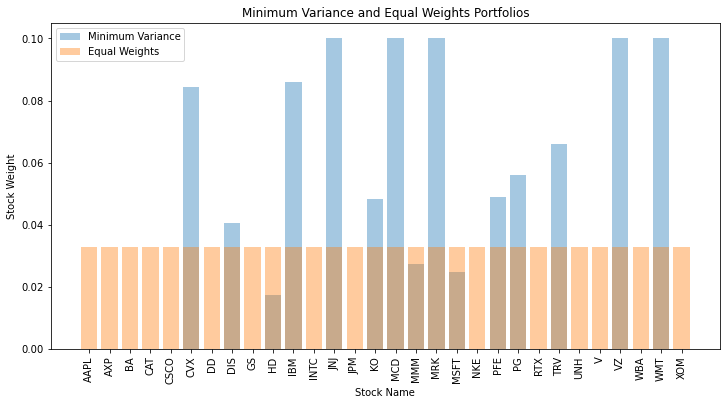

In [334]:
min_var_cleaned = pd.DataFrame(cleaned_weights_min_var, index=[0])

plt.subplots(figsize=(12,6))
plt.title('Minimum Variance and Equally Weighted Portfolios')
plt.bar(min_var_cleaned.T.index, min_var_cleaned.T[0], alpha=0.4, label='Minimum Variance')
plt.bar(min_var_cleaned.T.index, 0.033, alpha=0.4, label='Equal Weights')
plt.xlabel('Stock Name')
plt.ylabel('Stock Weight')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Model Evaluation and Backtesting

In [226]:
from pyfolio import timeseries
perf_func = timeseries.perf_stats 

## Baseline Portfolio Stats

In [335]:
# Calculate Baseline stats which is equally weighted portfolio represented by the DJIA Index
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_a2c_daily_return.loc[0,'date'],
        end = df_a2c_daily_return.loc[len(df_a2c_daily_return)-1,'date'])

baseline_stats = backtest_stats(baseline_df, value_col_name = 'close')
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1507, 8)
Annual return          0.096479
Cumulative returns     0.734637
Annual volatility      0.194633
Sharpe ratio           0.571552
Calmar ratio           0.260148
Stability              0.861136
Max drawdown          -0.370862
Omega ratio            1.128832
Sortino ratio          0.784377
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.887452
Daily value at risk   -0.024080
dtype: float64


## Minimum Variance Portfolio Stats 

In [336]:
# Calculate stats for minimum variance portfolio
df_min_var_daily_returns = pd.DataFrame(min_var_portfolio.account_value.pct_change())
df_min_var_daily_returns = df_min_var_daily_returns.reset_index()
df_min_var_daily_returns.columns = ['date','daily_return']

min_var_strat = convert_daily_return_to_pyfolio_ts(df_min_var_daily_returns)
min_var_stats_all = perf_func(returns=min_var_strat, 
                              factor_returns=min_var_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

## RL Model Portfolios Stats

In [337]:
# Calculate stats for the portfolios
a2c_strat = convert_daily_return_to_pyfolio_ts(df_a2c_daily_return)
a2c_perf_stats_all = perf_func(returns=a2c_strat, 
                              factor_returns=a2c_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

ppo_strat = convert_daily_return_to_pyfolio_ts(df_ppo_daily_return)
ppo_perf_stats_all = perf_func(returns=ppo_strat, 
                              factor_returns=ppo_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

ddpg_strat = convert_daily_return_to_pyfolio_ts(df_ddpg_daily_return)
ddpg_perf_stats_all = perf_func(returns=ddpg_strat, 
                              factor_returns=ddpg_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

sac_strat = convert_daily_return_to_pyfolio_ts(df_sac_daily_return)
sac_perf_stats_all = perf_func(returns=sac_strat, 
                              factor_returns=sac_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

td3_strat = convert_daily_return_to_pyfolio_ts(df_td3_daily_return)
td3_perf_stats_all = perf_func(returns=td3_strat, 
                              factor_returns=td3_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [338]:
# Concat all stats into a single dataframe
perf_stats_data = {
    "A2C": a2c_perf_stats_all,
    "PPO": ppo_perf_stats_all,
    "DDPG": ddpg_perf_stats_all,
    "SAC": sac_perf_stats_all,
    "TD3": td3_perf_stats_all,
    "Min. Var": min_var_stats_all,
    "DJIA (Baseline)": baseline_stats
}

perf_stats_all = pd.concat(perf_stats_data, axis = 1)

In [339]:
perf_stats_all

,A2C,PPO,DDPG,SAC,TD3,Min. Var,DJIA (Baseline)
Annual return,0.152779,0.127581,0.132222,0.131351,0.128219,0.110112,0.096479
Cumulative returns,1.341516,1.051438,1.102489,1.092828,1.058394,0.868444,0.734637
Annual volatility,0.192711,0.192303,0.185913,0.190336,0.191468,0.154622,0.194633
Sharpe ratio,0.834423,0.721028,0.761416,0.744099,0.726227,0.753755,0.571552
Calmar ratio,0.436289,0.354269,0.384694,0.375081,0.360530,0.384392,0.260148
Stability,0.929432,0.911116,0.917785,0.928392,0.908983,0.954660,0.861136
Max drawdown,-0.350180,-0.360124,-0.343707,-0.350194,-0.355640,-0.286457,-0.370862
Omega ratio,1.193529,1.165014,1.174443,1.172050,1.166186,1.171862,1.128832
Sortino ratio,1.187276,1.011202,1.069069,1.041008,1.019710,1.054639,0.784377
Skew,-0.065860,-0.348264,-0.416392,-0.428959,-0.284921,NaN,NaN


## Plot for cumulative returns of all the portfolios

In [340]:
import plotly
import plotly.graph_objs as go

In [341]:
# Calculate cumprod for each portfolio model
a2c_cumprod =(df_a2c_daily_return.daily_return+1).cumprod()-1
ppo_cumprod =(df_ppo_daily_return.daily_return+1).cumprod()-1
ddpg_cumprod =(df_ddpg_daily_return.daily_return+1).cumprod()-1
sac_cumprod =(df_sac_daily_return.daily_return+1).cumprod()-1
td3_cumprod =(df_td3_daily_return.daily_return+1).cumprod()-1
min_var_cumprod =(min_var_portfolio.account_value.pct_change()+1).cumprod()-1
dji_cumprod =(baseline_returns+1).cumprod()-1

In [342]:
time_ind = pd.Series(df_a2c_daily_return.date)

In [343]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumprod, mode = 'lines', name = 'A2C (RL Portfolio Allocation)')
trace1_portfolio = go.Scatter(x = time_ind, y = ppo_cumprod, mode = 'lines', name = 'PPO (RL Portfolio Allocation)')
trace2_portfolio = go.Scatter(x = time_ind, y = ddpg_cumprod, mode = 'lines', name = 'DDPG (RL Portfolio Allocation)')
trace3_portfolio = go.Scatter(x = time_ind, y = sac_cumprod, mode = 'lines', name = 'SAC (RL Portfolio Allocation)')
trace4_portfolio = go.Scatter(x = time_ind, y = td3_cumprod, mode = 'lines', name = 'TD3 (RL Portfolio Allocation)')
trace5_portfolio = go.Scatter(x = time_ind, y = dji_cumprod, mode = 'lines', name = 'DJIA (Equally Weighted)')
trace6_portfolio = go.Scatter(x = time_ind, y = min_var_cumprod, mode = 'lines', name = 'Minimum Variance')

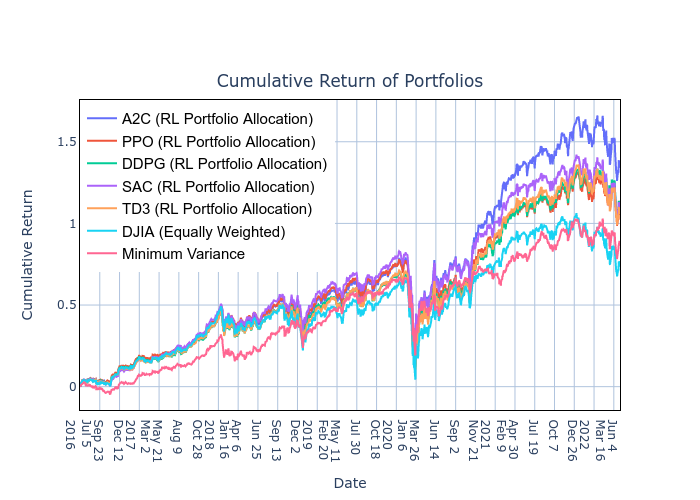

In [344]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)
fig.add_trace(trace3_portfolio)
fig.add_trace(trace4_portfolio)
fig.add_trace(trace5_portfolio)
fig.add_trace(trace6_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)

fig.update_layout(title={
        'text': "Cumulative Return of Portfolios",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_layout(
    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    xaxis_title="Date",
    yaxis_title="Cumulative Return",
    xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show("png")

We can see that the cumulative return of A2C model is highest than the other portfolios. Hence A2C is the best performing algorithm in our case.

## Plot of Full Tear Sheet for A2C model

Start date,2016-07-05
End date,2022-06-28
Total months,71
,Backtest
Annual return,15.304%
Cumulative returns,134.334%
Annual volatility,19.277%
Sharpe ratio,0.84
Calmar ratio,0.44
Stability,0.93
Max drawdown,-35.018%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.02,2020-02-12,2020-03-23,2020-09-02,146
1,15.74,2018-10-03,2018-12-24,2019-02-25,104
2,15.05,2022-03-29,2022-06-17,NaT,NaN
3,10.98,2018-01-26,2018-03-23,2018-08-27,152
4,8.46,2020-09-02,2020-10-28,2020-11-09,49


Stress Events,mean,min,max
New Normal,0.06%,-10.80%,11.92%


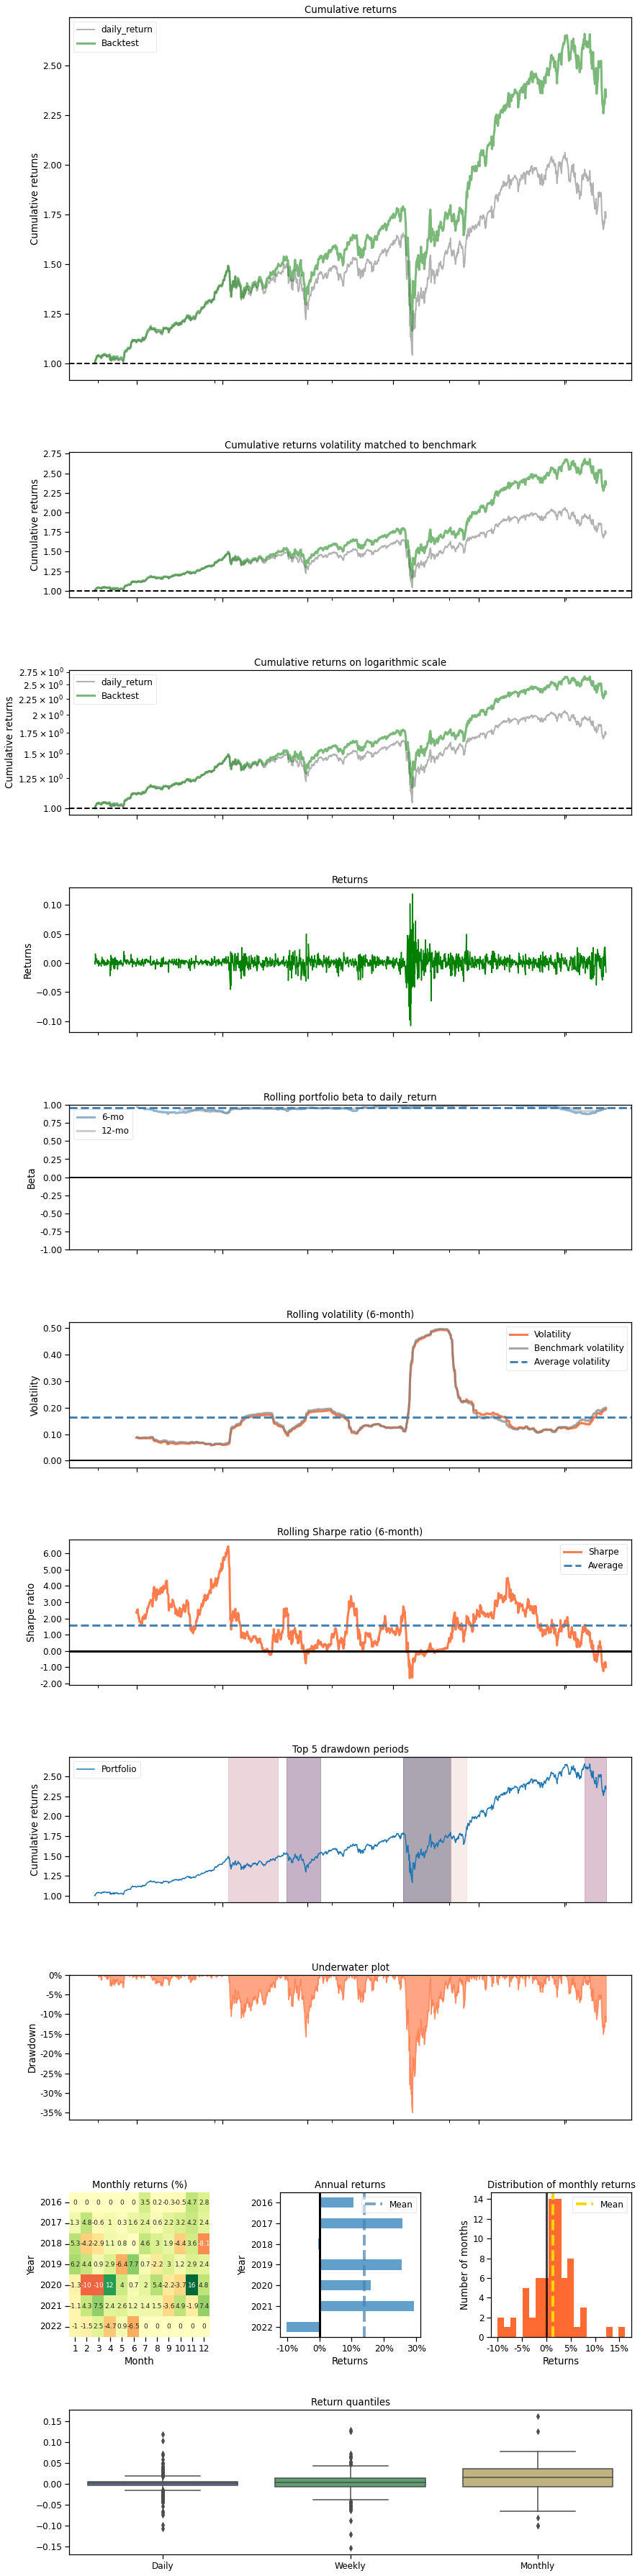

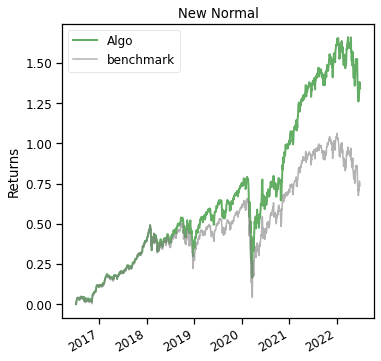

In [350]:
import pyfolio
%matplotlib inline

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = a2c_strat,
                                       benchmark_rets=baseline_returns, set_context=False)